# Load libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import numpy as np

from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm, bootstrap, wilcoxon
import csv

/var/folders/jn/x2x9w_8n77b_g5cnyyfbzc9w0000gp/T/ipykernel_17090/2192224211.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# Define Color maps

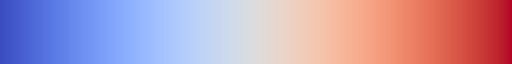

In [2]:
scw = []

with open('../../data/processed_data/common/smooth-cool-warm-table-float-1024.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i > 0:
            r = [float(i) for i in rows]
            scw.append(tuple(r[1:]))
            scw.append(r[0])
            
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = list(seq) + [(None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)

c = colors.ColorConverter().to_rgb
rvb = make_colormap(scw)
rvb

# Color palette

In [3]:
blue = [0.229999504, 0.298998934, 0.754000139]
red = [0.706000136, 0.015991824, 0.150000072]
purple = [0.4588, 0.4392, 0.7020]
mint = [0.1059, 0.6196, 0.4667]

# Figure 3b

In [4]:
energy = np.load('../../data/processed_data/extended_data_figure_4/T176_2018_05_15_fold1_energies.npz')
curvature = energy['curvature']
peak = np.argmax(curvature)

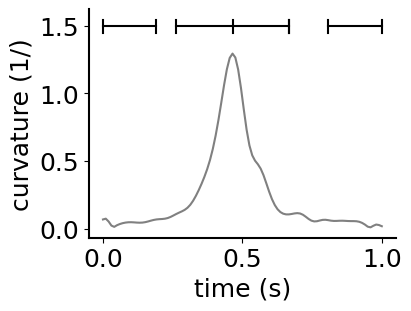

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), constrained_layout=True)
x = np.linspace(0, 1, 100)
ax.plot(x, curvature, color='gray')
ax.plot([x[0], x[19]], [curvature[peak]+0.2, curvature[peak]+0.2], markersize=15, color='black')
ax.plot([x[0], x[0]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')
ax.plot([x[19], x[19]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')

ax.plot([x[peak-20], x[peak+20]], [curvature[peak]+0.2, curvature[peak]+0.2], markersize=15, color='black')
ax.plot([x[peak-20], x[peak-20]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')
ax.plot([x[peak], x[peak]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')
ax.plot([x[peak+20], x[peak+20]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')
ax.plot([x[peak+20], x[peak+20]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')

ax.plot([x[-20], x[-1]], [curvature[peak]+0.2, curvature[peak]+0.2], markersize=15, color='black')
ax.plot([x[-20], x[-20]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')
ax.plot([x[-1], x[-1]], [curvature[peak]+0.2-0.05, curvature[peak]+0.2+0.05], markersize=15, color='black')

ax.set_xlabel("time (s)", fontsize=18)
ax.set_ylabel("curvature (1/)", fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(axis='both', which='major', labelsize=18)

# Figure 3c

In [6]:
import os
folder_path = '../../data/processed_data/extended_data_figure_4/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [7]:
fold=1
mean_energy_0s = []
mean_energy_1s = []
mean_energy_2s = []
mean_energy_3s = []
mean_energy_4s = []
peaks = []

early = 20
file_names_energies = np.sort([filename for filename in file_names if str(fold)+"_energies" in filename])
for filename in file_names_energies:
    energy = np.load(folder_path + filename)
    curvature = energy['curvature']
    curvature[:20] = np.nan
    curvature[65:] = np.nan
    peak = np.nanargmax(curvature)
    peaks.append(peak)
    mean_energy_0s.append(np.mean(np.mean(
        (energy['energy_auto'][:,0:1] - energy['energy_input'][:,0:1]) / (energy['energy_auto'][:,0:1] + energy['energy_input'][:,0:1] + 1e-8), axis=1
    )))
    mean_energy_1s.append(np.mean(np.mean(
        (energy['energy_auto'][:,1:early] - energy['energy_input'][:,1:early]) / (energy['energy_auto'][:,1:early] + energy['energy_input'][:,1:early] + 1e-8), axis=1
    )))
    mean_energy_2s.append(np.mean(np.mean(
        (energy['energy_auto'][:,peak-early:peak] - energy['energy_input'][:,peak-early:peak]) / (energy['energy_auto'][:,peak-early:peak] + energy['energy_input'][:,peak-early:peak] + 1e-8), axis=1
    )))
    mean_energy_3s.append(np.mean(np.mean(
        (energy['energy_auto'][:,peak:peak+early] - energy['energy_input'][:,peak:peak+early]) / (energy['energy_auto'][:,peak:peak+early] + energy['energy_input'][:,peak:peak+early] + 1e-8), axis=1
    )))
    mean_energy_4s.append(np.mean(np.mean(
        (energy['energy_auto'][:,-early:] - energy['energy_input'][:,-early:]) / (energy['energy_auto'][:,-early:] + energy['energy_input'][:,-early:] + 1e-8), axis=1
    )))

In [8]:
from scipy.stats import norm, bootstrap
res_0 = bootstrap((mean_energy_0s,), np.median, n_resamples=1000, confidence_level=0.95)
res_1 = bootstrap((mean_energy_1s,), np.median, n_resamples=1000, confidence_level=0.95)
res_2 = bootstrap((mean_energy_2s,), np.median, n_resamples=1000, confidence_level=0.95)
res_3 = bootstrap((mean_energy_3s,), np.median, n_resamples=1000, confidence_level=0.95)
res_4 = bootstrap((mean_energy_4s,), np.median, n_resamples=1000, confidence_level=0.95)

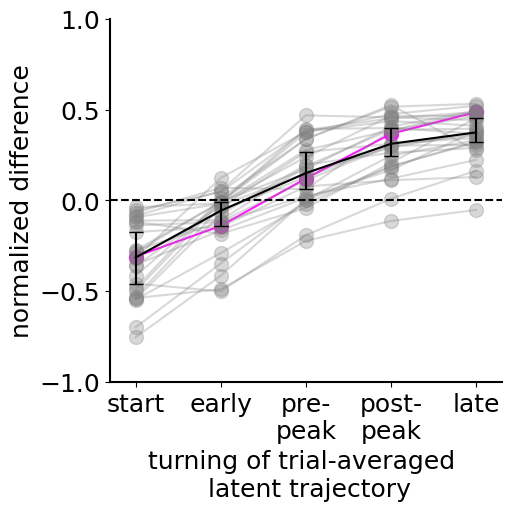

In [9]:
ybot = [
    np.median(mean_energy_0s) - res_0.confidence_interval.low,
    np.median(mean_energy_1s) - res_1.confidence_interval.low,
    np.median(mean_energy_2s) - res_2.confidence_interval.low,
    np.median(mean_energy_3s) - res_3.confidence_interval.low,
    np.median(mean_energy_4s) - res_4.confidence_interval.low
]
ytop = [
    res_0.confidence_interval.high - np.median(mean_energy_0s),
    res_1.confidence_interval.high - np.median(mean_energy_1s),
    res_2.confidence_interval.high - np.median(mean_energy_2s),
    res_3.confidence_interval.high - np.median(mean_energy_3s),
    res_4.confidence_interval.high - np.median(mean_energy_4s)
]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

choose=4 # this is the example session used in Figure 2

ax.plot(
        [1, 2, 3, 4, 5], 
        [
            mean_energy_0s[choose],
            mean_energy_1s[choose],
            mean_energy_2s[choose],
            mean_energy_3s[choose],
            mean_energy_4s[choose]
        ], '-o', markersize=10, color='magenta', alpha=0.9
)

for i in range(choose):
    ax.plot(
            [1, 2, 3, 4, 5], 
            [
                mean_energy_0s[i],
                mean_energy_1s[i],
                mean_energy_2s[i],
                mean_energy_3s[i],
                mean_energy_4s[i]
            ], '-o', markersize=10, color='gray', alpha=0.3
    )

for i in range(choose+1, len(mean_energy_0s)):
    ax.plot(
        [1, 2, 3, 4, 5], 
        [
            mean_energy_0s[i],
            mean_energy_1s[i],
            mean_energy_2s[i],
            mean_energy_3s[i],
            mean_energy_4s[i]
        ], '-o', markersize=10, color='gray', alpha=0.3)
ax.hlines(y=0, xmin=0.7, xmax=5.3, linestyle='--', linewidth=1.5, color='black')
ax.errorbar(
    [1, 2, 3, 4, 5], 
    [
        np.median(mean_energy_0s),
        np.median(mean_energy_1s),
        np.median(mean_energy_2s),
        np.median(mean_energy_3s),
        np.median(mean_energy_4s)
    ], yerr=(ybot, ytop), fmt='-', markersize=10, capsize=5, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set_xticks([1, 2, 3, 4, 5], labels=['start', 'early', 'pre-\npeak', 'post-\npeak','late'], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel("normalized difference", fontsize=18)
ax.set_xlabel("turning of trial-averaged \n latent trajectory", fontsize=18)
ax.set_xlim([0.7, 5.3])
ax.set_ylim([-1, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])

# Figure 3d

In [10]:
session_names = [
    'T176_2018_05_03',
    'T176_2018_05_04',
    'T176_2018_05_10',
    'T176_2018_05_15',
    'T176_2018_05_21',
    'T176_2018_05_30',
    'T176_2018_06_04',
    'T176_2018_06_06',
    'T176_2018_06_08',
    'T176_2018_06_11',
    'T176_2018_06_13',
    'T176_2018_06_14',
    'T176_2018_06_19',
    'T212_2019_08_14',
    'T219_2019_12_05',
    'T219_2019_12_17',
    'T219_2019_12_30',
    'T223_2019_12_17',
    'T240_2020_10_22',
    'T240_2020_10_23',
    'T240_2020_11_01',
    'T176_2018_05_08',
    'T176_2018_05_18',
    'T176_2018_05_23',
    'T176_2018_05_28',
    'T176_2018_05_31',
    'T212_2019_08_19'
]

edf3eh = np.load('../../data/processed_data/extended_data_figure_3/panels_e-h.npz')
session_neurons=edf3eh['session_neurons']
r2_findr_priors_l1=edf3eh['r2_findr_priors_l1']
pc_explained_l1=edf3eh['pc_explained_l1']
r2_findr_priors_l2=edf3eh['r2_findr_priors_l2']
pc_explained_l2=edf3eh['pc_explained_l2']
r2_findr_priors_l3=edf3eh['r2_findr_priors_l3']
pc_explained_l3=edf3eh['pc_explained_l3']
r2_findr_priors_l4=edf3eh['r2_findr_priors_l4']
pc_explained_l4=edf3eh['pc_explained_l4']
r2_findr_priors_pc_l3=edf3eh['r2_findr_priors_pc_l3']
r2_findr_priors_pc_l4=edf3eh['r2_findr_priors_pc_l4']

pvalues_l12 = []
for session_id in range(27):
    res = wilcoxon(
        r2_findr_priors_l2[session_neurons[0,session_id]:session_neurons[1,session_id]] - \
        r2_findr_priors_l1[session_neurons[0,session_id]:session_neurons[1,session_id]]
    )
    pvalues_l12.append(res.pvalue)
pvalues_l12 = np.array(pvalues_l12)
pvalues_l12 = pvalues_l12[np.argsort(session_names)]

In [11]:
fold=1
mean_angle_0s = []
mean_angle_1s = []
mean_angle_2s = []
mean_angle_3s = []
mean_angle_4s = []

curved = []

early = 20
file_names_angles = np.sort([filename for filename in file_names if str(fold)+"_angles" in filename])
for filename in file_names_angles:
    angles = np.load(folder_path + filename)
    Leftevidence = angles['Leftevidence']
    Rightevidence = angles['Rightevidence']
    Rightevidence0hat = gaussian_filter1d(Rightevidence[:100, 0], 3, mode='nearest')
    Rightevidence1hat = gaussian_filter1d(Rightevidence[:100, 1], 3, mode='nearest')
    Leftevidence0hat = gaussian_filter1d(Leftevidence[:100, 0], 3, mode='nearest')
    Leftevidence1hat = gaussian_filter1d(Leftevidence[:100, 1], 3, mode='nearest')
    
    energy = np.load(folder_path + filename.replace("angles", "energies"))
    curvature = energy['curvature']
    curvature[:20] = np.nan
    curvature[65:] = np.nan
    peak = np.nanargmax(curvature)

    if max(Leftevidence[99:100,0], key=abs) > 0:
        flip_horizontally = -1
    else:
        flip_horizontally = 1
    if max(Leftevidence[99:100,1], key=abs) > 0:
        flip_vertically = -1
    else:
        flip_vertically = 1

    if (fold==1) and ('T176_2018_06_06' in filename):
        flip_horizontally = flip_horizontally
        flip_vertically = -flip_vertically
    if (fold==4):
        if ('T176_2018_06_06' in filename) or ('T176_2018_06_13' in filename) or ('T176_2018_05_28' in filename):
            flip_horizontally = flip_horizontally
            flip_vertically = -flip_vertically

    dx_dt = np.gradient(Rightevidence0hat)
    dy_dt = np.gradient(Rightevidence1hat)
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
    velocityR = np.array([[flip_horizontally*dx_dt[i]/ds_dt[i], flip_vertically*dy_dt[i]/ds_dt[i]] for i in range(dx_dt.size)])

    dx_dt = np.gradient(Leftevidence0hat)
    dy_dt = np.gradient(Leftevidence1hat)
    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)
    velocityL = np.array([[-flip_horizontally*dx_dt[i]/ds_dt[i], -flip_vertically*dy_dt[i]/ds_dt[i]] for i in range(dx_dt.size)])

    mean_angle_0s.append(np.mean(
        [
            0, 
            (np.sign(velocityL[0, 1]) * np.arccos(velocityL[0, 0]) * 180/np.pi + \
             np.sign(velocityR[0, 1]) * np.arccos(velocityR[0, 0]) * 180/np.pi)/2
        ]
    ))
    mean_angle_1s.append(np.mean(
        (np.sign(velocityL[:early, 1]) * np.arccos(velocityL[:early, 0]) * 180/np.pi + \
        np.sign(velocityR[:early, 1]) * np.arccos(velocityR[:early, 0]) * 180/np.pi)/2
    ))
    mean_angle_2s.append(np.mean(
        (np.sign(velocityL[peak-early:peak, 1]) * np.arccos(velocityL[peak-early:peak, 0]) * 180/np.pi + \
        np.sign(velocityR[peak-early:peak, 1]) * np.arccos(velocityR[peak-early:peak, 0]) * 180/np.pi)/2
    ))
    mean_angle_3s.append(np.mean(
        (np.sign(velocityL[peak:peak+early, 1]) * np.arccos(velocityL[peak:peak+early, 0]) * 180/np.pi + \
        np.sign(velocityR[peak:peak+early, 1]) * np.arccos(velocityR[peak:peak+early, 0]) * 180/np.pi)/2
    ))
    mean_angle_4s.append(np.mean(
        (np.sign(velocityL[-early:, 1]) * np.arccos(velocityL[-early:, 0]) * 180/np.pi + \
        np.sign(velocityR[-early:, 1]) * np.arccos(velocityR[-early:, 0]) * 180/np.pi)/2
    ))

mean_angle_0s = np.array(mean_angle_0s)
mean_angle_1s = np.array(mean_angle_1s)
mean_angle_2s = np.array(mean_angle_2s)
mean_angle_3s = np.array(mean_angle_3s)
mean_angle_4s = np.array(mean_angle_4s)

In [12]:
res_0 = bootstrap((mean_angle_0s[(pvalues_l12 < 0.001)],), np.median, n_resamples=1000, confidence_level=0.95)
res_1 = bootstrap((mean_angle_1s[(pvalues_l12 < 0.001)],), np.median, n_resamples=1000, confidence_level=0.95)
res_2 = bootstrap((mean_angle_2s[(pvalues_l12 < 0.001)],), np.median, n_resamples=1000, confidence_level=0.95)
res_3 = bootstrap((mean_angle_3s[(pvalues_l12 < 0.001)],), np.median, n_resamples=1000, confidence_level=0.95)
res_4 = bootstrap((mean_angle_4s[(pvalues_l12 < 0.001)],), np.median, n_resamples=1000, confidence_level=0.95)

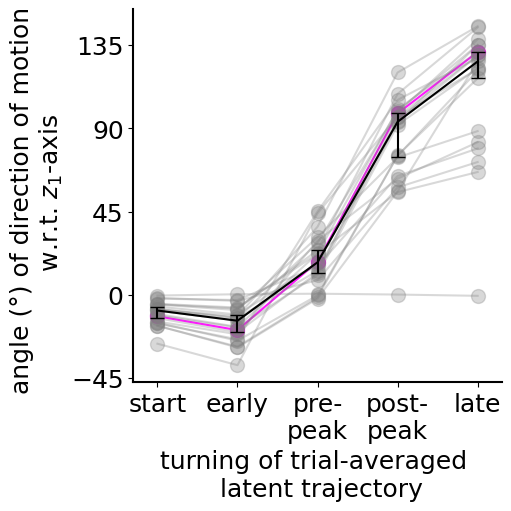

In [13]:
ybot = [
    np.median(mean_angle_0s[(pvalues_l12 < 0.001)]) - res_0.confidence_interval.low,
    np.median(mean_angle_1s[(pvalues_l12 < 0.001)]) - res_1.confidence_interval.low,
    np.median(mean_angle_2s[(pvalues_l12 < 0.001)]) - res_2.confidence_interval.low,
    np.median(mean_angle_3s[(pvalues_l12 < 0.001)]) - res_3.confidence_interval.low,
    np.median(mean_angle_4s[(pvalues_l12 < 0.001)]) - res_4.confidence_interval.low
]
ytop = [
    res_0.confidence_interval.high - np.median(mean_angle_0s[(pvalues_l12 < 0.001)]),
    res_1.confidence_interval.high - np.median(mean_angle_1s[(pvalues_l12 < 0.001)]),
    res_2.confidence_interval.high - np.median(mean_angle_2s[(pvalues_l12 < 0.001)]),
    res_3.confidence_interval.high - np.median(mean_angle_3s[(pvalues_l12 < 0.001)]),
    res_4.confidence_interval.high - np.median(mean_angle_4s[(pvalues_l12 < 0.001)])
]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

choose=4

ax.plot(
        [1, 2, 3, 4, 5], 
        [
            mean_angle_0s[choose],
            mean_angle_1s[choose],
            mean_angle_2s[choose],
            mean_angle_3s[choose],
            mean_angle_4s[choose]
        ], '-o', markersize=10, color='magenta', alpha=0.9
)

for i in range(choose):
    ax.plot(
            [1, 2, 3, 4, 5], 
            [
                mean_angle_0s[i],
                mean_angle_1s[i],
                mean_angle_2s[i],
                mean_angle_3s[i],
                mean_angle_4s[i]
            ], '-o', markersize=10, color='gray', alpha=0.3
    )

for i in range(choose+1, len(mean_angle_0s)):
    yes = (pvalues_l12 < 0.001)
    if yes[i]:
        ax.plot(
            [1, 2, 3, 4, 5], 
            [
                mean_angle_0s[i],
                mean_angle_1s[i],
                mean_angle_2s[i],
                mean_angle_3s[i],
                mean_angle_4s[i]
            ], '-o', markersize=10, color='gray', alpha=0.3)
        
ax.errorbar(
    [1, 2, 3, 4, 5], 
    [
        np.median(mean_angle_0s[(pvalues_l12 < 0.001)]),
        np.median(mean_angle_1s[(pvalues_l12 < 0.001)]),
        np.median(mean_angle_2s[(pvalues_l12 < 0.001)]),
        np.median(mean_angle_3s[(pvalues_l12 < 0.001)]),
        np.median(mean_angle_4s[(pvalues_l12 < 0.001)])
    ], yerr=(ybot, ytop), fmt='-', markersize=10, capsize=5, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set_xticks([1, 2, 3, 4, 5], labels=['start', 'early', 'pre-\npeak', 'post-\npeak','late'], fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel("angle (°) of direction of motion \n w.r.t. $z_1$-axis", fontsize=18)
ax.set_xlabel("turning of trial-averaged \n latent trajectory", fontsize=18)
ax.set_xlim([0.7, 5.3])
ax.set_yticks([-45, 0, 45, 90, 135])